***The following code was built and tested on Google Colab.***

In [3]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.models import Model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00
time: 263 µs (started: 2023-12-11 19:25:11 +00:00)


In [6]:
!wget -P /content/drive/MyDrive/DSCI552/final-project/data http://dataverse.jpl.nasa.gov/api/access/datafile/83039

--2023-12-11 19:25:13--  http://dataverse.jpl.nasa.gov/api/access/datafile/83039
Resolving dataverse.jpl.nasa.gov (dataverse.jpl.nasa.gov)... 128.149.107.132
Connecting to dataverse.jpl.nasa.gov (dataverse.jpl.nasa.gov)|128.149.107.132|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dataverse.jpl.nasa.gov/api/access/datafile/83039 [following]
--2023-12-11 19:25:13--  https://dataverse.jpl.nasa.gov/api/access/datafile/83039
Connecting to dataverse.jpl.nasa.gov (dataverse.jpl.nasa.gov)|128.149.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2738356883 (2.5G) [application/zip]
Saving to: ‘/content/drive/MyDrive/DSCI552/final-project/data/83039.15’

83039.15            100%[===================>]   2.55G  21.8MB/s    in 2m 5s   

2023-12-11 19:27:19 (20.8 MB/s) - ‘/content/drive/MyDrive/DSCI552/final-project/data/83039.15’ saved [2738356883/2738356883]

time: 2min 7s (started: 2023-12-11 19:25:11 +00:00)


In [7]:
file_name = '/content/drive/MyDrive/DSCI552/final-project/data/83039'

with ZipFile(file_name, 'r') as zips:
  zips.extractall()
  print('Done')

Done
time: 42.1 s (started: 2023-12-11 19:27:19 +00:00)


In [8]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

# Head directory containing all image subframes.
data_head_dir = Path('/content/data/')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

time: 6.22 ms (started: 2023-12-11 19:28:01 +00:00)


In [9]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/DSCI552/final-project/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/DSCI552/final-project/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/DSCI552/final-project/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

time: 1.18 s (started: 2023-12-11 19:28:01 +00:00)


# Loading and pre processing the data + Image augmentation




In [10]:
def load_and_preprocess(img_loc, label):
  def _inner_function(img_loc, label):
      # Convert tensor to native type
      img_loc_str = img_loc.numpy().decode('utf-8')

      # Load image using PIL and convert to RGB
      img = Image.open(img_loc_str).convert('RGB')
      img = np.array(img)
      img = tf.image.resize(img, [299, 299])

      # Normalize the image to the [0, 1] range
      img = img / 255.0
      label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

      return img, label

  X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

  X.set_shape([299, 299, 3])
  y.set_shape([]) # Scalar

  return X, y


time: 597 µs (started: 2023-12-11 19:28:02 +00:00)


### Image Augmentation:

For image augmentation, I tried random contrast, random crop, flip and random zoom, and kept random contrast only for better model performance.

* The pictures used for this project are subareas of the photo of Mars took perpendicularly, it will not provide much additional information when flip or rotate the pictures.
* Pictures are plain and contains many duplicated subareas, random zoom didn't improve the model performance.


In [11]:
def load_and_preprocess_and_augmentation(img_loc, label): #For training data
  def _inner_function(img_loc, label):
    img_loc_str = img_loc.numpy().decode('utf-8')
    img = Image.open(img_loc_str).convert('RGB')

    # img = tf.image.random_crop(img, size=[250, 250, 3])
    # img = tf.image.random_flip_left_right(img)
    # img = tf.image.random_flip_up_down(img)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = np.array(img)
    img = tf.image.resize(img, [299, 299])

    # Normalize the image to the [0, 1] range
    img = img / 255.0

    # Convert label
    label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

    return img, label

  X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

  X.set_shape([299, 299, 3])
  y.set_shape([]) # Scalar

  return X, y

time: 559 µs (started: 2023-12-11 19:28:02 +00:00)


In [12]:
def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

time: 487 µs (started: 2023-12-11 19:28:02 +00:00)


In [13]:
# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

time: 171 ms (started: 2023-12-11 19:28:02 +00:00)


In [14]:
tf_data_val[:5]

[('/content/data/ESP_053223_1770_20480_22760_10240_12466/tiles/background/ESP_053223_1770_21377_21676_11137_11436.png',
  'background'),
 ('/content/data/ESP_053223_1770_20480_22760_10240_12466/tiles/background/ESP_053223_1770_21377_21676_11436_11735.png',
  'background'),
 ('/content/data/ESP_053223_1770_20480_22760_10240_12466/tiles/background/ESP_053223_1770_20779_21078_10838_11137.png',
  'background'),
 ('/content/data/ESP_053223_1770_20480_22760_10240_12466/tiles/background/ESP_053223_1770_20480_20779_12034_12333.png',
  'background'),
 ('/content/data/ESP_053223_1770_20480_22760_10240_12466/tiles/background/ESP_053223_1770_20480_20779_10240_10539.png',
  'background')]

time: 2.51 ms (started: 2023-12-11 19:28:03 +00:00)


In [15]:
#Train
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
#Image augmentation
tf_dataset_train = tf_dataset_train.map(load_and_preprocess_and_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

#Validation
random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

#Test
random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

time: 3.11 s (started: 2023-12-11 19:28:03 +00:00)


In [16]:
#Check imbalance and data format
for img, label in tf_dataset_train.take(10):
    print(label)

tf.Tensor([0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0], shape=(32,), dtype=int64)
tf.Tensor([0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1], shape=(32,), dtype=int64)
tf.Tensor([1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0], shape=(32,), dtype=int64)
tf.Tensor([1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0], shape=(32,), dtype=int64)
tf.Tensor([1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1], shape=(32,), dtype=int64)
tf.Tensor([1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1], shape=(32,), dtype=int64)
tf.Tensor([0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1], shape=(32,), dtype=int64)
tf.Tensor([1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0], shape=(32,), dtype=int64)
tf.Tensor([0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0], shape=(32,), dtype=int64)
tf.Tensor([0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 

In [ ]:
for img, label in tf_dataset_test.take(10):
    print(label)

tf.Tensor([1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1], shape=(32,), dtype=int64)
tf.Tensor([0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1], shape=(32,), dtype=int64)
tf.Tensor([0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0], shape=(32,), dtype=int64)
tf.Tensor([1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0], shape=(32,), dtype=int64)
tf.Tensor([1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1], shape=(32,), dtype=int64)
tf.Tensor([0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1], shape=(32,), dtype=int64)
tf.Tensor([0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1], shape=(32,), dtype=int64)
tf.Tensor([0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0], shape=(32,), dtype=int64)
tf.Tensor([0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1], shape=(32,), dtype=int64)
tf.Tensor([1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 

## Training CNN (Convolutional Neural Network) + MLP (Multi-Layer Perceptron)

Following is a three-layer CNN followed by a dense layer on the data:

* Dense layer (MLP) neurons: 128
* All layers: ReLU
* Softmax function, Batch normalization
* Dropout rate: 30%,
* L2 regularization: 0.1
* ADAM optimizer
* Cross entropy loss: sparse categorical crossentropy
* Output layer: Dense(2, activation='softmax')
* Learning rate: 0.00001

In [ ]:
def cnn_model():
    cnn_mlp_model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(299, 299, 3), kernel_regularizer=l2(0.1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.1)),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.00001)
    cnn_mlp_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return cnn_mlp_model

time: 848 µs (started: 2023-12-11 16:22:36 +00:00)


In [ ]:
model = cnn_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/DSCI552/final-project/cnn_mlp_best_model.h5', save_best_only=True, save_weights_only=False)

history = model.fit(tf_dataset_train,
                    epochs=20,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 26.2696 - accuracy: 0.7128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


928/928 [==============================] - 324s 334ms/step - loss: 26.2696 - accuracy: 0.7128 - val_loss: 17.0108 - val_accuracy: 0.8710
Epoch 2/20
928/928 [==============================] - 305s 328ms/step - loss: 13.0701 - accuracy: 0.7737 - val_loss: 10.2849 - val_accuracy: 0.7606
Epoch 3/20
928/928 [==============================] - 307s 330ms/step - loss: 8.6541 - accuracy: 0.8168 - val_loss: 8.1140 - val_accuracy: 0.6326
Epoch 4/20
928/928 [==============================] - 308s 331ms/step - loss: 6.7765 - accuracy: 0.8411 - val_loss: 6.5255 - val_accuracy: 0.7159
Epoch 5/20
928/928 [==============================] - 307s 331ms/step - loss: 5.7698 - accuracy: 0.8610 - val_loss: 5.4722 - val_accuracy: 0.8236
Epoch 6/20
928/928 [==============================] - 309s 332ms/step - loss: 5.1530 - accuracy: 0.8730 - val_loss: 5.1384 - val_accuracy: 0.7761
Epoch 7/20
928/928 [==============================] - 309s 333ms/step - loss: 4.7246 - accuracy: 0.8837 - val_loss: 4.8056 - val_ac

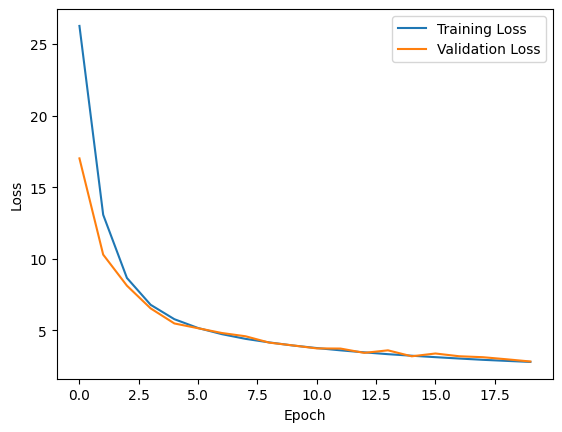

time: 187 ms (started: 2023-12-11 18:06:42 +00:00)


In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
#True labels for all models evaluation
true_labels_test = [label.numpy() for img, label in tf_dataset_test.unbatch()]
true_labels_train = [label.numpy() for img, label in tf_dataset_train.unbatch()]
true_labels_val = [label.numpy() for img, label in tf_dataset_val.unbatch()]

time: 3min 48s (started: 2023-12-11 21:31:21 +00:00)


Test dataset report:

In [ ]:
predictions_test = model.predict(tf_dataset_test)
predicted_classes_test = np.argmax(predictions_test, axis=1)
print(classification_report(true_labels_test, predicted_classes_test))

401/401 [==============================] - 52s 129ms/step
              precision    recall  f1-score   support

           0       0.35      0.44      0.39      4418
           1       0.66      0.57      0.61      8405

    accuracy                           0.52     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.52      0.53     12823

time: 52.4 s (started: 2023-12-11 18:10:42 +00:00)


Train dataset report:

In [ ]:
predictions_tr = model.predict(tf_dataset_train)
predicted_classes_tr = np.argmax(predictions_tr, axis=1)
print(classification_report(true_labels_train, predicted_classes_tr))

928/928 [==============================] - 195s 210ms/step
              precision    recall  f1-score   support

           0       0.42      0.45      0.43     12235
           1       0.59      0.56      0.58     17444

    accuracy                           0.52     29679
   macro avg       0.51      0.51      0.51     29679
weighted avg       0.52      0.52      0.52     29679

time: 3min 15s (started: 2023-12-11 18:11:34 +00:00)


Validation dataset report:

In [ ]:
predictions_val = model.predict(tf_dataset_val)
predicted_classes_val = np.argmax(predictions_val, axis=1)
print(classification_report(true_labels_val, predicted_classes_val))

353/353 [==============================] - 46s 130ms/step
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      7654
           1       0.33      0.41      0.37      3632

    accuracy                           0.54     11286
   macro avg       0.51      0.51      0.50     11286
weighted avg       0.57      0.54      0.55     11286

time: 46.2 s (started: 2023-12-11 18:14:50 +00:00)


# Transfer Learning

* EfficientNetB0
* ResNet50
* VGG 16



1. **EfficientNetB0**

* Dense layer neurons: 32
* L2 regularization: 0.1
* Dropout rate: 30% (For better model performance)
* Output layer: Dense(2, activation='softmax')
* Learning_rate: 0.000001
* Loss: sparse categorical crossentropy
* Batch size: 8
* *Prediction results may not be reliable. The model didn't fit with many combinations of hyperparameters. It was easy to overfitting after two or three epoches. The pre-trained layers of EfficientNetB0 may not suitable for this specific training dataset.*

In [22]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
  layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

model_en = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.00001)
model_en.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_en.fit(
    tf_dataset_train,
    epochs=11,
    validation_data=tf_dataset_val,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/DSCI552/final-project/en_best_model-epoch15.h5', save_best_only=True, save_weights_only=False)
    ],
    batch_size=8
)

Epoch 1/11
928/928 [==============================] - 315s 332ms/step - loss: 6.1173 - accuracy: 0.5345 - val_loss: 5.3557 - val_accuracy: 0.3192
Epoch 2/11
928/928 [==============================] - 309s 332ms/step - loss: 4.6785 - accuracy: 0.5446 - val_loss: 4.0777 - val_accuracy: 0.6428
Epoch 3/11
928/928 [==============================] - 308s 332ms/step - loss: 3.6219 - accuracy: 0.5533 - val_loss: 3.3057 - val_accuracy: 0.3218
Epoch 4/11
928/928 [==============================] - 309s 333ms/step - loss: 2.8552 - accuracy: 0.5585 - val_loss: 2.6858 - val_accuracy: 0.3218
Epoch 5/11
928/928 [==============================] - 306s 329ms/step - loss: 2.3089 - accuracy: 0.5610 - val_loss: 2.1233 - val_accuracy: 0.2727
Epoch 6/11
928/928 [==============================] - 306s 329ms/step - loss: 1.9192 - accuracy: 0.5618 - val_loss: 1.9298 - val_accuracy: 0.3218
Epoch 7/11
928/928 [==============================] - 306s 330ms/step - loss: 1.6422 - accuracy: 0.5660 - val_loss: 1.5817 -

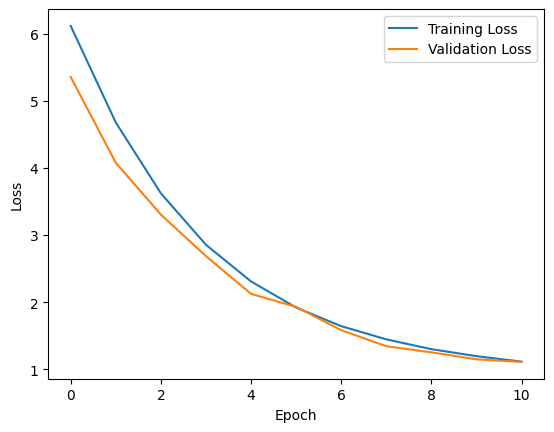

time: 175 ms (started: 2023-12-11 21:29:43 +00:00)


In [23]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
predictions_en_test = model_en.predict(tf_dataset_test)
predicted_classes_en_test = np.argmax(predictions_en_test, axis=1)
print(classification_report(true_labels_test, predicted_classes_en_test))

401/401 [==============================] - 75s 185ms/step
              precision    recall  f1-score   support

           0       0.32      0.03      0.05      4418
           1       0.65      0.97      0.78      8405

    accuracy                           0.65     12823
   macro avg       0.49      0.50      0.42     12823
weighted avg       0.54      0.65      0.53     12823

time: 1min 14s (started: 2023-12-11 21:36:00 +00:00)


In [27]:
predictions_en_train = model_en.predict(tf_dataset_train)
predicted_classes_en_train = np.argmax(predictions_en_train, axis=1)
print(classification_report(true_labels_train, predicted_classes_en_train))

928/928 [==============================] - 240s 258ms/step
              precision    recall  f1-score   support

           0       0.39      0.04      0.07     12235
           1       0.59      0.96      0.73     17444

    accuracy                           0.58     29679
   macro avg       0.49      0.50      0.40     29679
weighted avg       0.51      0.58      0.46     29679

time: 4min (started: 2023-12-11 21:37:14 +00:00)


In [28]:
predictions_en_val = model_en.predict(tf_dataset_val)
predicted_classes_en_val = np.argmax(predictions_en_val, axis=1)
print(classification_report(true_labels_val, predicted_classes_en_val))

353/353 [==============================] - 65s 185ms/step
              precision    recall  f1-score   support

           0       0.71      0.00      0.01      7654
           1       0.32      1.00      0.49      3632

    accuracy                           0.32     11286
   macro avg       0.51      0.50      0.25     11286
weighted avg       0.58      0.32      0.16     11286

time: 1min 5s (started: 2023-12-11 21:41:15 +00:00)


2. **ResNet50**

* Dense layer neurons: 128
* L2 regularization: 0.1
* Dropout rate: 30%
* Output layer: Dense(2, activation='softmax')
* Learning_rate: 0.00001
* Loss: sparse categorical crossentropy

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
  layer.trainable = False

# Add new top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the new model
model_rn = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model_rn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use the features calculated by networks for training
history = model_rn.fit(
    tf_dataset_train,
    epochs=21,
    validation_data=tf_dataset_val,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/DSCI552/final-project/rn_best_model.h5', save_best_only=True, save_weights_only=False)
    ],
    batch_size=8
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/21
928/928 [==============================] - 402s 427ms/step - loss: 19.7003 - accuracy: 0.6914 - val_loss: 15.1451 - val_accuracy: 0.8050
Epoch 2/21
928/928 [==============================] - 392s 422ms/step - loss: 12.0161 - accuracy: 0.7712 - val_loss: 8.9973 - val_accuracy: 0.9042
Epoch 3/21
928/928 [==============================] - 392s 422ms/step - loss: 7.1355 - accuracy: 0.7909 - val_loss: 5.1742 - val_accuracy: 0.9156
Epoch 4/21
928/928 [==============================] - 392s 423ms/step - loss: 4.1266 - accuracy: 0.8058 - val_loss: 2.8974 - val_accuracy: 0.9221
Epoch 5/21
928/928 [==============================] - 393s 423ms/step - loss: 2.3792 - accuracy: 0.8123 - val_loss: 1.6343 - val_accuracy: 0.9238
Epoch 6/21
928/928 [==============================] - 392s 422ms/step - loss: 1.4455 - accuracy: 0.8192 - val_loss: 1.1250 - val_accuracy: 0.8423
Epoch 7/21
928/928 [==============================] - 39

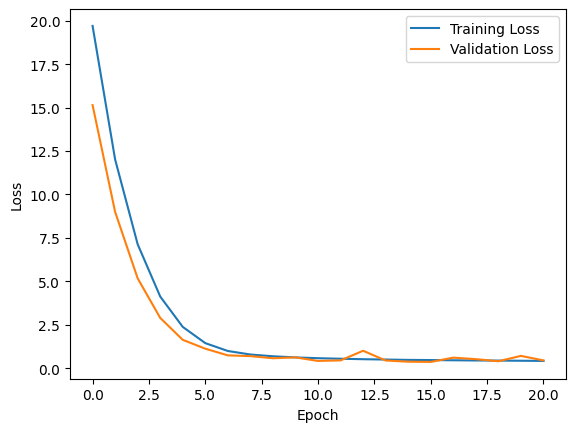

time: 218 ms (started: 2023-12-11 00:01:13 +00:00)


In [ ]:
# Plot training and validation loss 下载h5
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions_rn_test = model_rn.predict(tf_dataset_test)
predicted_classes_rn_test = np.argmax(predictions_rn_test, axis=1)
print(classification_report(true_labels_test, predicted_classes_rn_test))

401/401 [==============================] - 102s 254ms/step
              precision    recall  f1-score   support

           0       0.34      0.46      0.39      4418
           1       0.65      0.54      0.59      8405

    accuracy                           0.51     12823
   macro avg       0.50      0.50      0.49     12823
weighted avg       0.55      0.51      0.52     12823

time: 1min 42s (started: 2023-12-11 00:26:07 +00:00)


In [ ]:
predictions_rn_train = model_rn.predict(tf_dataset_train)
predicted_classes_rn_train = np.argmax(predictions_rn_train, axis=1)
print(classification_report(true_labels_train, predicted_classes_rn_train))

928/928 [==============================] - 303s 326ms/step
              precision    recall  f1-score   support

           0       0.41      0.60      0.49     12235
           1       0.59      0.40      0.48     17444

    accuracy                           0.49     29679
   macro avg       0.50      0.50      0.49     29679
weighted avg       0.52      0.49      0.48     29679

time: 5min 3s (started: 2023-12-11 00:20:02 +00:00)


In [ ]:
predictions_rn_val = model_rn.predict(tf_dataset_val)
predicted_classes_rn_val = np.argmax(predictions_rn_val, axis=1)
print(classification_report(true_labels_val, predicted_classes_rn_val))

353/353 [==============================] - 90s 254ms/step
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      7654
           1       0.32      0.39      0.35      3632

    accuracy                           0.54     11286
   macro avg       0.50      0.50      0.50     11286
weighted avg       0.56      0.54      0.55     11286

time: 1min 29s (started: 2023-12-11 00:27:49 +00:00)


3. **VGG16**

* Dense layer neurons: 128
* L2 regularization: 0.0005
* Dropout rate: 40% (For better model performance, I decreased regularizer and used higher dropout rate for regularization. It reduced the overfitting issue.)
* Output layer: Dense(2, activation='softmax')
* Learning_rate: 0.0001
* Loss: sparse categorical crossentropy

Trouble shooting ref:
* https://datascience.stackexchange.com/questions/82435/why-an-increasing-validation-loss-and-validation-accuracy-signifies-overfitting
* https://github.com/keras-team/keras/issues/3755

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
  layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x) #Change the regularizer to 0.0005
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x) #Decreased regularizer, used higher dropout rate for regularization
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model_vgg.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_vgg.fit(
    tf_dataset_train,
    epochs=21,
    validation_data=tf_dataset_val,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/DSCI552/final-project/vgg_best_model.h5', save_best_only=True, save_weights_only=False)
    ],
    batch_size=8
)

Epoch 1/21
928/928 [==============================] - 491s 527ms/step - loss: 0.4733 - accuracy: 0.8227 - val_loss: 0.7476 - val_accuracy: 0.7663
Epoch 2/21
928/928 [==============================] - 485s 522ms/step - loss: 0.3283 - accuracy: 0.8908 - val_loss: 0.8598 - val_accuracy: 0.7555
Epoch 3/21
928/928 [==============================] - 483s 520ms/step - loss: 0.2870 - accuracy: 0.9049 - val_loss: 0.7796 - val_accuracy: 0.7772
Epoch 4/21
928/928 [==============================] - 483s 520ms/step - loss: 0.2552 - accuracy: 0.9175 - val_loss: 0.5923 - val_accuracy: 0.8213
Epoch 5/21
928/928 [==============================] - 484s 522ms/step - loss: 0.2340 - accuracy: 0.9261 - val_loss: 0.5713 - val_accuracy: 0.8354
Epoch 6/21
928/928 [==============================] - 485s 523ms/step - loss: 0.2200 - accuracy: 0.9307 - val_loss: 0.4974 - val_accuracy: 0.8460
Epoch 7/21
928/928 [==============================] - 484s 521ms/step - loss: 0.2121 - accuracy: 0.9337 - val_loss: 0.8962 -

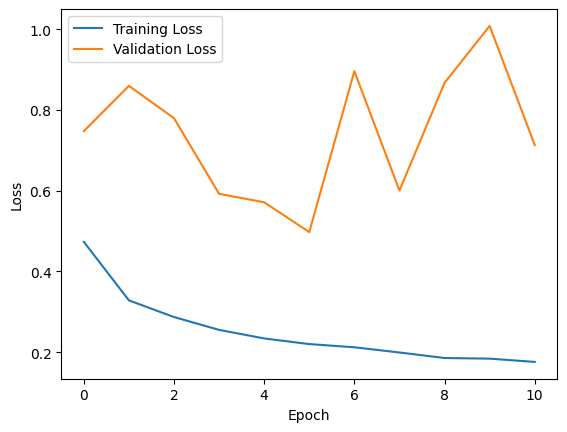

time: 140 ms (started: 2023-12-11 03:38:44 +00:00)


In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions_vgg_test = model_vgg.predict(tf_dataset_test)
predicted_classes_vgg_test = np.argmax(predictions_vgg_test, axis=1)
print(classification_report(true_labels_test, predicted_classes_vgg_test))

401/401 [==============================] - 138s 344ms/step
              precision    recall  f1-score   support

           0       0.35      0.42      0.38      4418
           1       0.66      0.59      0.62      8405

    accuracy                           0.53     12823
   macro avg       0.51      0.51      0.50     12823
weighted avg       0.55      0.53      0.54     12823

time: 2min 18s (started: 2023-12-11 03:38:51 +00:00)


In [ ]:
predictions_vgg_train = model_vgg.predict(tf_dataset_train)
predicted_classes_vgg_train = np.argmax(predictions_vgg_train, axis=1)
print(classification_report(true_labels_train, predicted_classes_vgg_train))

928/928 [==============================] - 369s 398ms/step
              precision    recall  f1-score   support

           0       0.42      0.47      0.44     12235
           1       0.59      0.54      0.57     17444

    accuracy                           0.51     29679
   macro avg       0.51      0.51      0.51     29679
weighted avg       0.52      0.51      0.52     29679

time: 6min 9s (started: 2023-12-11 03:41:09 +00:00)


In [ ]:
predictions_vgg_val = model_vgg.predict(tf_dataset_val)
predicted_classes_vgg_val = np.argmax(predictions_vgg_val, axis=1)
print(classification_report(true_labels_val, predicted_classes_vgg_val))

353/353 [==============================] - 116s 329ms/step
              precision    recall  f1-score   support

           0       0.68      0.53      0.60      7654
           1       0.33      0.48      0.39      3632

    accuracy                           0.51     11286
   macro avg       0.50      0.51      0.49     11286
weighted avg       0.57      0.51      0.53     11286

time: 1min 56s (started: 2023-12-11 03:47:19 +00:00)


### Model Evaluation Summary:

In this project, four models have almost same performance.

* ***VGG16*** model has a sightly better test f1 score (0.54), and a better performance on detecting frost (precision: 0.66; recall: 0.59). However, its validation loss fluctuated after 6 epochs, which means the model may be overfitting.

* Generally, I think ***CNN+MLP*** and ***ResNet50*** models both have a reliable performance.<br>
** CNN+MLP (weighted avg): f1 score: 0.53 | precision: 0.55 | recall: 0.52<br>
** ResNet50 (weighted avg): f1 score: 0.52 | precision: 0.55 | recall: 0.51
** Both models has a decreasing validation loss.

* Although ***EfficientNetB0*** model has a same-level test performance, the result may not be very reliable. The prediction result is highly imbalanced. With many combinations of hyperparameters, the model was easy to be overfitting after two or three epoches.
** EfficientNetB0 (weighted avg): f1 score: 0.53 | precision: 0.54 | recall: 0.65



In [ ]:
print('CNN + MLP model test result:')
print(classification_report(true_labels_test, predicted_classes_test))

CNN + MLP model test result:
              precision    recall  f1-score   support

           0       0.35      0.44      0.39      4418
           1       0.66      0.57      0.61      8405

    accuracy                           0.52     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.52      0.53     12823

time: 29.3 ms (started: 2023-12-11 18:17:32 +00:00)


In [ ]:
print('ResNet50 model test result:')
print(classification_report(true_labels_test, predicted_classes_rn_test))
print('VGG16 model test result:')
print(classification_report(true_labels_test, predicted_classes_vgg_test))

ResNet50 model test result:
              precision    recall  f1-score   support

           0       0.34      0.46      0.39      4418
           1       0.65      0.54      0.59      8405

    accuracy                           0.51     12823
   macro avg       0.50      0.50      0.49     12823
weighted avg       0.55      0.51      0.52     12823

VGG16 model test result:
              precision    recall  f1-score   support

           0       0.35      0.42      0.38      4418
           1       0.66      0.59      0.62      8405

    accuracy                           0.53     12823
   macro avg       0.51      0.51      0.50     12823
weighted avg       0.55      0.53      0.54     12823

time: 50.3 ms (started: 2023-12-11 04:11:58 +00:00)


In [29]:
print('EfficientNetB0 model test result:')
print(classification_report(true_labels_test, predicted_classes_en_test))

EfficientNetB0 model test result:
              precision    recall  f1-score   support

           0       0.32      0.03      0.05      4418
           1       0.65      0.97      0.78      8405

    accuracy                           0.65     12823
   macro avg       0.49      0.50      0.42     12823
weighted avg       0.54      0.65      0.53     12823

time: 24.3 ms (started: 2023-12-11 21:42:21 +00:00)
